# Modeling for Tanzania Water Wells

In [7]:
cd "Data Set"

C:\Users\artur\Documents\Tanzania-wells----project_3\Data Set


### Importing tools I will need in my modeling.

In [3]:
pip install --upgrade xgboost


Requirement already up-to-date: xgboost in c:\users\artur\anaconda3\lib\site-packages (1.0.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd 
import numpy as np 

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Function to help encode

In [5]:
def encode_me(column, dataframe):
    '''
    Receive column name and dataframe and return dataframe with dummy variables and removed columns.
    column: String for the column we want to turn into dummy variables.
    dataframe: dataframe we will work with.
    '''
    dummies = pd.get_dummies(dataframe[column]) #creating dummy variables in our dataframe.
    dummies.drop(dummies.columns[0], axis=1, inplace=True) #dropping columns no longer needed
    rename_dict = {}
    for c in dummies.columns:
        rename_dict[c] = str(column) + '_' + str(c) 
    dummies.rename(columns = rename_dict,inplace=True) #renaming dataframe from dummies to orignal name
    dataframe = dataframe.join(dummies) #having the dataframe saved as the encoded data.
    dataframe.drop(column,axis=1, inplace=True)
    return dataframe

## Data clean up for future modeling

In [8]:
data_X = pd.read_csv('X.csv')
data_y = pd.read_csv('y.csv')

In [9]:
data_water = data_X.merge(data_y, how='inner', on='id') 
print(data_water.shape)
data_water.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [10]:
data_water.keys()

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [11]:
data_water.drop(columns= ['id', 'funder', 'installer', 'num_private', 'scheme_management', 'scheme_name', 'permit', 'amount_tsh',
                         'waterpoint_type_group', 'source', 'region_code', 'district_code', 'management_group', 'payment_type',
                          'extraction_type', 'extraction_type_group', 'recorded_by', 'ward', 'lga', 'wpt_name', 'subvillage', 
                          'quantity_group', 'longitude', 'latitude', 'date_recorded', 'water_quality' ], axis=1, inplace=True)

In [12]:
data_water.head()

,gps_height,basin,region,population,public_meeting,construction_year,extraction_type_class,management,payment,quality_group,quantity,source_type,source_class,waterpoint_type,status_group
0,1390,Lake Nyasa,Iringa,109,True,1999,gravity,vwc,pay annually,good,enough,spring,groundwater,communal standpipe,functional
1,1399,Lake Victoria,Mara,280,NaN,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,686,Pangani,Manyara,250,True,2009,gravity,vwc,pay per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,263,Ruvuma / Southern Coast,Mtwara,58,True,1986,submersible,vwc,never pay,good,dry,borehole,groundwater,communal standpipe multiple,non functional
4,0,Lake Victoria,Kagera,0,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [13]:
print(data_water.isna().sum())

gps_height                  0
basin                       0
region                      0
population                  0
public_meeting           3334
construction_year           0
extraction_type_class       0
management                  0
payment                     0
quality_group               0
quantity                    0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64


In [14]:
data_water['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [15]:
data_water['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [16]:
data_water['public_meeting'].dropna(inplace= True)

In [17]:
print(data_water['public_meeting'].isna().value_counts())

False    56066
Name: public_meeting, dtype: int64


In [18]:
data_water['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [19]:
data = encode_me('basin', data_water)

data = encode_me('region', data)

#data = encode_me('public_meeting', data)

data = encode_me('extraction_type_class', data)

data = encode_me('management', data)

data = encode_me('payment', data)

data = encode_me('quality_group', data)

data = encode_me('quantity', data)

data = encode_me('source_type', data)

data = encode_me('source_class', data)

data = encode_me('waterpoint_type', data)

In [20]:
#list comprehensions

#essentially running a for loop to generate a list, but "under the hood" python implements faster
#also the code is shorter / cleaner

throwaway = [1,2,3,4,5]

throaway2 = [value/7 if value==4 else 0 for value in throwaway]



In [21]:
data['public_meeting'] = [1 if x==True else 0 for x in data['public_meeting']]
data['public_meeting'].value_counts()

1    51011
0     8389
Name: public_meeting, dtype: int64

In [22]:
data.keys()

Index(['gps_height', 'population', 'public_meeting', 'construction_year',
       'status_group', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'region_Dar es Salaam', 'region_Dodoma', 'region_Iringa',
       'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Mbeya', 'region_Morogoro',
       'region_Mtwara', 'region_Mwanza', 'region_Pwani', 'region_Rukwa',
       'region_Ruvuma', 'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_rope pump', 'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'management_other',
       'management_other - school', 'management_parastatal',
       '

## Train Test Split

In [23]:
data_X = data[['gps_height', 'population', 'construction_year', 'status_group',
       'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji',
       'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'region_Dar es Salaam', 'region_Dodoma', 'region_Iringa',
       'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Mbeya', 'region_Morogoro',
       'region_Mtwara', 'region_Mwanza', 'region_Pwani', 'region_Rukwa',
       'region_Ruvuma', 'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_rope pump', 'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'management_other',
       'management_other - school', 'management_parastatal',
       'management_private operator', 'management_trust', 'management_unknown',
       'management_vwc', 'management_water authority',
       'management_water board', 'management_wua', 'management_wug',
       'payment_other', 'payment_pay annually', 'payment_pay monthly',
       'payment_pay per bucket', 'payment_pay when scheme fails',
       'payment_unknown', 'quality_group_fluoride', 'quality_group_good',
       'quality_group_milky', 'quality_group_salty', 'quality_group_unknown',
       'quantity_enough', 'quantity_insufficient', 'quantity_seasonal',
       'quantity_unknown', 'source_type_dam', 'source_type_other',
       'source_type_rainwater harvesting', 'source_type_river/lake',
       'source_type_shallow well', 'source_type_spring',
       'source_class_surface', 'source_class_unknown',
       'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other']]

data_X_pred = data_X.drop(columns='status_group')
data_X_pred

,gps_height,population,construction_year,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,...,source_type_shallow well,source_type_spring,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,1390,109,1999,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1399,280,2010,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,686,250,2009,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,263,58,1986,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1210,125,1999,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
59396,1212,56,1996,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
59397,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
59398,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [24]:
X= data_X_pred
y= data_X['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))




47520 11880 47520 11880


## Removal of outliers

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77]),
 <a list of 77 Text xticklabel objects>)

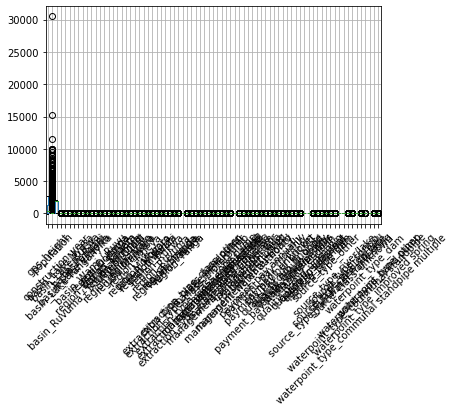

In [25]:
data_X_pred.boxplot()
plt.xticks(rotation=45)

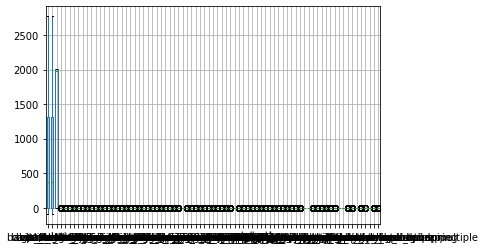

In [26]:
data_X_pred['population'] = data_X_pred.loc[data_X_pred['population']<5000]
data_X_pred.boxplot()

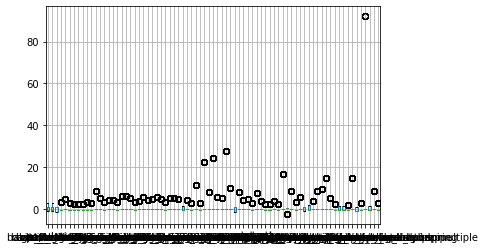

In [27]:
ss = StandardScaler()
column_names = data_X_pred.columns
data_X_pred = pd.DataFrame(ss.fit_transform(data_X_pred))
data_X_pred.columns = column_names
data_X_pred.boxplot()

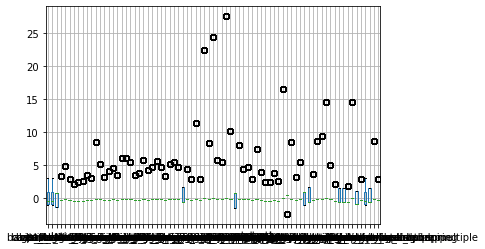

In [28]:
data_X_pred['waterpoint_type_dam'] = data_X_pred.loc[data_X_pred['waterpoint_type_dam']<80]
data_X_pred.boxplot()

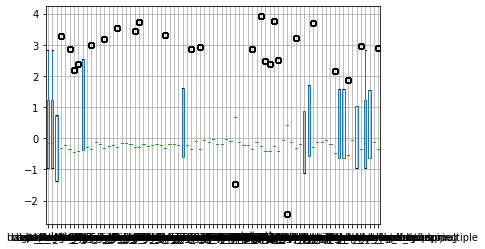

In [29]:
for x in data_X_pred:
    data_X_pred = data_X_pred.loc[data_X_pred[x]<4]
    
data_X_pred.boxplot()

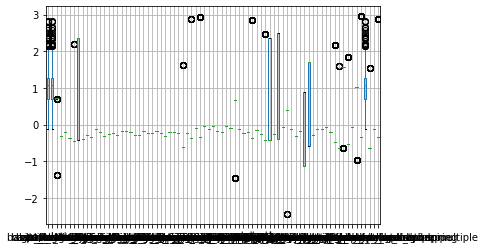

In [30]:
for x in data_X_pred:
    data_X_pred = data_X_pred.loc[data_X_pred[x]<3]
    
data_X_pred.boxplot()

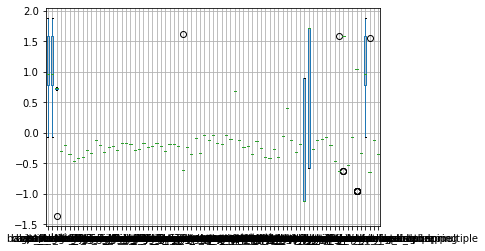

In [31]:
for x in data_X_pred:
    data_X_pred = data_X_pred.loc[data_X_pred[x]<2.1]
    
data_X_pred.boxplot()

# Naive Bays

In [32]:
nb = GaussianNB()
nb.fit(X_train,y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

# Random Forest Classifier

In [33]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

C:\Users\artur\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [82]:
rfc_X_test = rfc.predict(X_test)
accuracy_rfc = str(metrics.accuracy_score(y_test, rfc_X_test))
accuracy_rfc

'0.7724747474747474'

In [68]:
rfc.feature_importances_


array([1.82024832e-01, 1.07590373e-01, 1.09608535e-01, 6.30153671e-03,
       5.43696387e-03, 9.08681541e-03, 9.85226368e-03, 6.41704997e-03,
       7.78864732e-03, 5.06490152e-03, 6.61606504e-03, 1.28534466e-03,
       3.69360116e-03, 9.66124719e-03, 3.65152763e-03, 4.16334821e-03,
       5.99836719e-03, 2.44618772e-03, 3.77523097e-03, 3.46437581e-03,
       3.23873047e-03, 3.68413832e-03, 2.90053225e-03, 4.37758606e-03,
       3.90329516e-03, 3.21527684e-03, 4.02591369e-03, 5.64684185e-03,
       4.23231079e-03, 3.03115601e-03, 3.73357083e-03, 1.05976771e-02,
       5.99205100e-03, 3.39608033e-02, 1.61444078e-03, 1.17818227e-02,
       6.43198680e-04, 2.29251822e-03, 4.34722874e-04, 4.37421336e-03,
       4.51260402e-03, 4.49322528e-04, 1.76072775e-03, 1.47772698e-02,
       2.84990732e-03, 4.95921455e-03, 3.97391303e-03, 5.15338993e-03,
       2.69854999e-03, 1.04499405e-02, 1.45106740e-02, 1.80077817e-02,
       9.64549225e-03, 1.37056904e-02, 1.05483765e-03, 1.25164981e-02,
      

In [35]:
lst=[]
for coef,columns in zip(list(data.columns),list(rfc.feature_importances_)):
    lst.append((columns,coef))

sorted(lst)


[(5.935400434505762e-05, 'waterpoint_type_communal standpipe'),
 (0.00043472287442864794, 'extraction_type_class_wind-powered'),
 (0.0004493225278132377, 'management_parastatal'),
 (0.0006431986803700422, 'extraction_type_class_rope pump'),
 (0.0008646823019111656, 'source_type_spring'),
 (0.0009564686388217819, 'quantity_unknown'),
 (0.0010548376480234442, 'payment_pay when scheme fails'),
 (0.0012853446592560902, 'basin_Ruvuma / Southern Coast'),
 (0.0016144407844546258, 'extraction_type_class_motorpump'),
 (0.0017607277486863023, 'management_private operator'),
 (0.0019907730881214055, 'quality_group_fluoride'),
 (0.0022925182187819304, 'extraction_type_class_submersible'),
 (0.0024461877181595334, 'region_Kigoma'),
 (0.002698549992255974, 'management_wua'),
 (0.002832786869799565, 'waterpoint_type_dam'),
 (0.0028374857224152113, 'quantity_insufficient'),
 (0.002849907319966586, 'management_unknown'),
 (0.002863503783167161, 'quantity_seasonal'),
 (0.00290053225125414, 'region_Mbeya

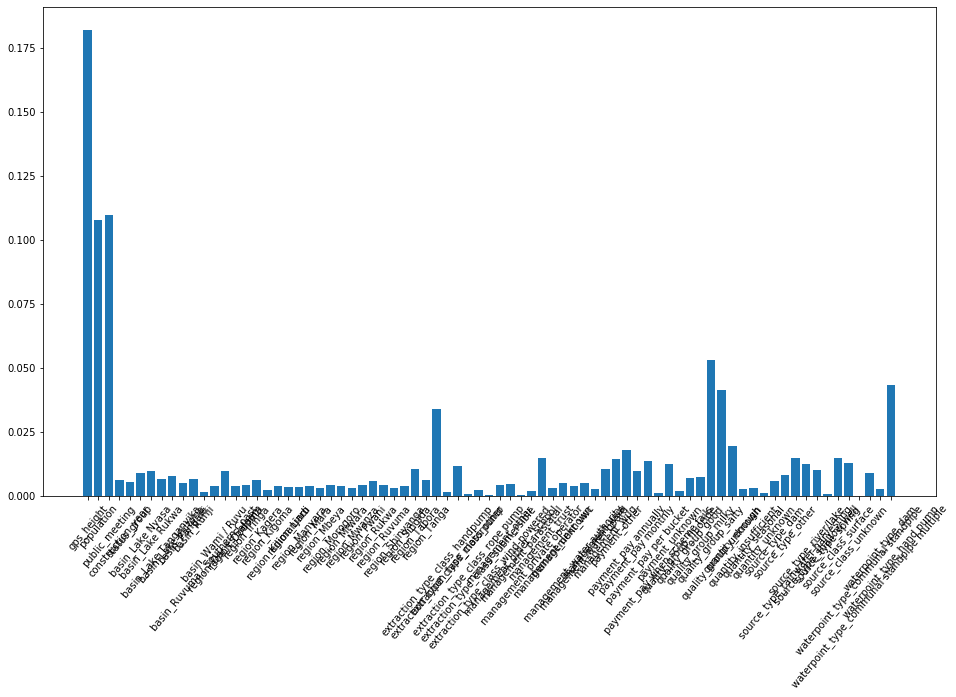

In [42]:
keys_f =[]
values_f =[]
    
for l in lst:
    values_f.append(l[0])
    keys_f.append(l[1])

plt.figure(figsize=(16,9))
plt.bar(keys_f, values_f)
plt.xticks(rotation=50);


# Decision Tree Classifier

In [79]:
dt1 = DecisionTreeClassifier()
dt1.fit(X_train, y_train)
dt_X_preds1 =  dt1.predict(X_test)


In [80]:
accuracy_dt1 = str(metrics.accuracy_score(y_test, dt_X_preds1))
recall_dt1 = str(metrics.recall_score(y_test, dt_X_preds1, average='micro'))
precision_dt1 = str(metrics.precision_score(y_test, dt_X_preds1, average='micro'))
f1_dt1 = str(metrics.f1_score(y_test, dt_X_preds1, average='micro'))



In [81]:
print(accuracy_dt1)


0.7445286195286195


# Random Forest Classifier with hyper parameter tuning

In [47]:
rfc1 = RandomForestClassifier()


In [48]:
rdc_params = {'n_estimators':range(2,10,2), 
              'max_features':['auto', 'log2', 'sqrt']}

In [49]:
cv_rfc = GridSearchCV(rfc1, rdc_params, cv=5) 

cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [90]:
cv_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
y_hat_train = cv_rfc.best_estimator_.predict(X_train)

### second parameter tuning

In [51]:
rdc_params = {'n_estimators':range(2,10,2), 
              'max_features': [2,5,10,15]}

### model acurracy

In [89]:
cv_rfc_X_test = cv_rfc.best_estimator_.predict(X_test)
accuracy_cvrfc = str(metrics.accuracy_score(y_test, cv_rfc_X_test))
accuracy_cvrfc

'0.7710437710437711'

## Confusion Matrix

In [53]:
cm = confusion_matrix(y_train, y_hat_train, labels=['non functional', 'functional', 'functional needs repair'])

Text(0.5, 0, 'Predicted functionality')

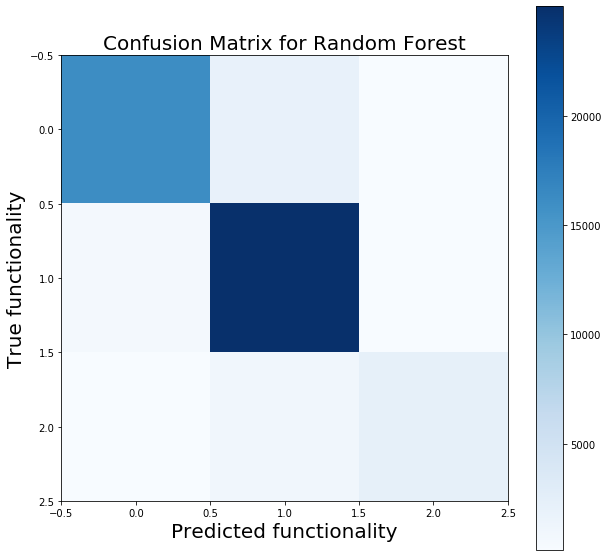

In [113]:
plt.figure(figsize=(10,10))
plt.imshow(cm,  cmap=plt.cm.Blues) 
plt.colorbar()
plt.title('Confusion Matrix for Random Forest',fontsize=20)
plt.ylabel('True functionality',fontsize=20)
plt.xlabel('Predicted functionality',fontsize=20)


## XGBoost


In [61]:
xg = XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [62]:
xg.feature_importances_

array([0.00484809, 0.00465284, 0.00801993, 0.0155275 , 0.01422076,
       0.00536073, 0.01505797, 0.00574342, 0.00580383, 0.00928425,
       0.00547406, 0.00859919, 0.01587478, 0.03447436, 0.00630775,
       0.02097896, 0.0128685 , 0.00510862, 0.00482848, 0.01663346,
       0.01734793, 0.00796943, 0.00505639, 0.009457  , 0.01081138,
       0.01186177, 0.00909475, 0.01803267, 0.01194975, 0.00521577,
       0.00694255, 0.00833417, 0.01143579, 0.04519277, 0.00514154,
       0.01026684, 0.00214244, 0.00564986, 0.00229467, 0.00369307,
       0.00925122, 0.00297995, 0.00527317, 0.00989281, 0.00534189,
       0.01156688, 0.00640211, 0.00841044, 0.00284149, 0.01464061,
       0.0104044 , 0.016038  , 0.0063186 , 0.00854546, 0.00476814,
       0.00394375, 0.01255552, 0.00568694, 0.00950862, 0.03524143,
       0.03544438, 0.08685923, 0.01969938, 0.00878718, 0.0064958 ,
       0.01386092, 0.00802425, 0.00622755, 0.01255143, 0.0121316 ,
       0.        , 0.00808429, 0.03202483, 0.        , 0.00973

In [63]:
xglist=[]
for coef,columns in zip(list(data.columns),list(xg.feature_importances_)):
    xglist.append((columns,coef))

sorted(lst)


[(5.935400434505762e-05, 'waterpoint_type_communal standpipe'),
 (0.00043472287442864794, 'extraction_type_class_wind-powered'),
 (0.0004493225278132377, 'management_parastatal'),
 (0.0006431986803700422, 'extraction_type_class_rope pump'),
 (0.0008646823019111656, 'source_type_spring'),
 (0.0009564686388217819, 'quantity_unknown'),
 (0.0010548376480234442, 'payment_pay when scheme fails'),
 (0.0012853446592560902, 'basin_Ruvuma / Southern Coast'),
 (0.0016144407844546258, 'extraction_type_class_motorpump'),
 (0.0017607277486863023, 'management_private operator'),
 (0.0019907730881214055, 'quality_group_fluoride'),
 (0.0022925182187819304, 'extraction_type_class_submersible'),
 (0.0024461877181595334, 'region_Kigoma'),
 (0.002698549992255974, 'management_wua'),
 (0.002832786869799565, 'waterpoint_type_dam'),
 (0.0028374857224152113, 'quantity_insufficient'),
 (0.002849907319966586, 'management_unknown'),
 (0.002863503783167161, 'quantity_seasonal'),
 (0.00290053225125414, 'region_Mbeya

In [76]:
xg_X_test = xg.predict(X_test)
accuracy_xg = str(metrics.accuracy_score(y_test, xg_X_test))
accuracy_xg

'0.7819023569023569'

In [88]:
recall_xg = str(metrics.recall_score(y_test, xg_X_test, average='micro'))
precision_xg = str(metrics.precision_score(y_test, xg_X_test, average='micro'))
f1_xg = str(metrics.f1_score(y_test, xg_X_test, average='micro'))
print(recall_xg)
print(precision_xg)
print(f1_xg)

0.7819023569023569
0.7819023569023569
0.7819023569023569


In [84]:
y_hat_test = xg.predict(X_test)

In [86]:
cm_xg = confusion_matrix(y_test, y_hat_test, labels=['non functional', 'functional', 'functional needs repair'])
cm_xg

array([[3253, 1293,   26],
       [ 515, 5883,   59],
       [ 130,  568,  153]], dtype=int64)

# XGBoost With Parameter tuning

In [92]:
xg_params = {'max_depth' : range(0,15,2) , 
             'booster' : ['gbtree', 'gblinear', 'dart']}

In [93]:
xg_gs = XGBClassifier()

In [94]:
cv_xgb = GridSearchCV(xg_gs, xg_params, cv=5) 

cv_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                   

In [95]:
cv_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [96]:
xg_gs_X_test = cv_xgb.best_estimator_.predict(X_test)
accuracy_xg_gs = str(metrics.accuracy_score(y_test, xg_gs_X_test))
accuracy_xg_gs

'0.7860269360269361'

In [99]:
y_hat_test_gs = cv_xgb.best_estimator_.predict(X_test)

In [100]:
cm_xg_gs = confusion_matrix(y_test, y_hat_test_gs, labels=['non functional', 'functional', 'functional needs repair'])
cm_xg_gs

array([[3383, 1128,   61],
       [ 595, 5743,  119],
       [ 113,  526,  212]], dtype=int64)

Text(0.5, 0, 'Predicted functionalityy')

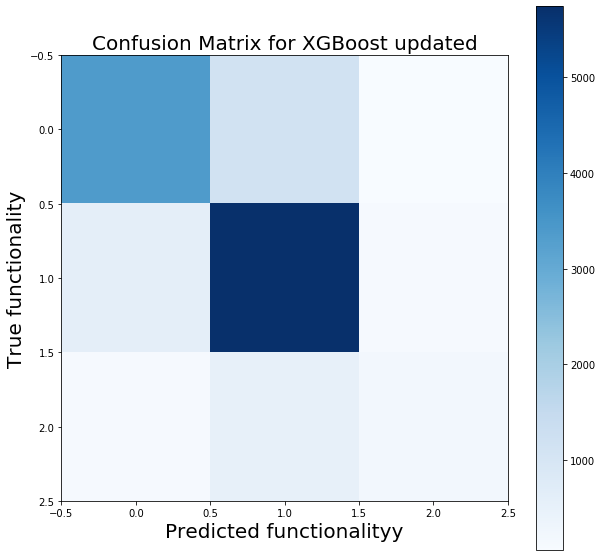

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(cm_xg_gs,  cmap=plt.cm.Blues) 
plt.colorbar()
plt.title('Confusion Matrix for XGBoost updated',fontsize=20)
plt.ylabel('True functionality',fontsize=20)
plt.xlabel('Predicted functionalityy',fontsize=20)


### Model Comparison

In [104]:
#untuned rf

accuracy_rfc = str(metrics.accuracy_score(y_test, rfc_X_test))
recall_rfc = str(metrics.recall_score(y_test, rfc_X_test, average='micro'))
precision_rfc = str(metrics.precision_score(y_test, rfc_X_test, average='micro'))
f1_rfc = str(metrics.f1_score(y_test, rfc_X_test, average='micro'))

print(accuracy_rfc)
print(recall_rfc)
print(precision_rfc)
print(f1_rfc)

0.7724747474747474
0.7724747474747474
0.7724747474747474
0.7724747474747474


In [101]:
#first tuned rf: max_f = sqrt, n_est=8

accuracy_rf = str(metrics.accuracy_score(y_test, xg_X_test))
recall_rf = str(metrics.recall_score(y_test, xg_X_test, average='micro'))
precision_rf = str(metrics.precision_score(y_test, xg_X_test, average='micro'))
f1_rf = str(metrics.f1_score(y_test, xg_X_test, average='micro'))



0.7819023569023569
0.7819023569023569
0.7819023569023569
0.7819023569023569


In [105]:
#xg untuned

accuracy_xg = str(metrics.accuracy_score(y_test, xg_X_test))
recall_xg = str(metrics.recall_score(y_test, xg_X_test, average='micro'))
precision_xg = str(metrics.precision_score(y_test, xg_X_test, average='micro'))
f1_xg = str(metrics.f1_score(y_test, xg_X_test, average='micro'))

print(accuracy_xg)
print(recall_xg)
print(precision_xg)
print(f1_xg)

In [ ]:
#first tuned xg: max depth=10, booster=gbtree

recall_xg = str(metrics.recall_score(y_test, xg_X_test, average='micro'))
precision_xg = str(metrics.precision_score(y_test, xg_X_test, average='micro'))
f1_xg = str(metrics.f1_score(y_test, xg_X_test, average='micro'))